In [1]:
from collections import Counter
import os
import pandas as pd
from qiime2 import Artifact
from qiime2.metadata import Metadata
from qiime2.plugins.feature_classifier.methods import classify_consensus_vsearch
from qiime2.plugins.feature_table.methods import filter_samples, filter_seqs, relative_frequency
from qiime2.plugins.feature_table.visualizers import summarize
from qiime2.plugins.taxa.visualizers import barplot
from qiime2 import Visualization
from scipy import stats
import seaborn as sns
import tempfile

%matplotlib inline

In [2]:
working_dir = os.path.abspath('../')
refs_dir = working_dir + '/taxonomy_references'
references = ['silva', 'silva_extended', 'gg', 'gg_extended']

In [3]:
ft = Artifact.load(working_dir + '/input/feature_table.qza')
seqs = Artifact.load(working_dir + '/input/sequences.qza')
metadata = Metadata.load(working_dir + '/input/metadata.txt')

In [4]:
for reference in references:
    ref_seqs = Artifact.load(refs_dir + '/' + reference + '_sequences.qza')
    ref_tax = Artifact.load(refs_dir + '/' + reference + '_taxonomy.qza')
    classification_taxonomy, = classify_consensus_vsearch(seqs, ref_seqs,
                                                            ref_tax,
                                                          threads = 12)
    classification_taxonomy.save(working_dir + '/output/' + reference +
                                 '_classification_taxonomy1.qza')
    print(reference, 'done')

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-5enj6h9u/1e96b9c1-ac78-4aa4-9c74-f74058e1583a/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tmp/qiime2-archive-ub4s37m7/b41681fb-a4e7-4ef8-a23a-a26f1bcfd272/data/dna-sequences.fasta --threads 12 --output_no_hits --blast6out /tmp/tmpmya9s1yu

silva done
Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-5enj6h9u/1e96b9c1-ac78-4aa4-9c74-f74058e1583a/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects

In [5]:
df = metadata.to_dataframe()
df = df.drop(df.columns.difference(['#SampleID']), 1)
ids = Metadata(df)
for reference in references:
    taxonomy = Artifact.load(working_dir + '/output/' + reference +
                             '_classification_taxonomy1.qza')
    tbp, = barplot(ft, taxonomy, ids)
    tbp.save(working_dir + '/output/' + reference + '_tbp1.qzv')

In [6]:
#this is the cell within which to capture absolute numbers if we want to calculate absolute increases/decreases
#include absolute unassigned / chloro / mito columns in for loop and make sure they get spit out at the end
results = pd.DataFrame(columns = ['absolute unassigned', 'proportion unassigned',
                                  'absolute chloroplasts', 'proportion chloroplasts',
                                  'absolute mitochondria', 'proportion mitochondria',
                                  'reference taxonomy']).rename_axis('#SampleID')
with tempfile.TemporaryDirectory() as temp_dir:
    for reference in references:
        reference_results = pd.DataFrame().rename_axis('#SampleID')
        qzv = Visualization.load(working_dir + '/output/' + reference + '_tbp1.qzv')
        qzv.export_data(temp_dir)
        df = pd.read_csv(temp_dir + '/level-1.csv', index_col = 0)
        df['total'] = df.sum(1)
        df['proportion unassigned'] = df['Unassigned'] / df['total']
        reference_results['absolute unassigned'] = df['Unassigned']
        reference_results['proportion unassigned'] = df['proportion unassigned']
        if 'silva' in reference:
            df = pd.read_csv(temp_dir + '/level-4.csv', index_col = 0)
            df['total'] = df.sum(1)
            df['proportion chloroplasts'] = df['d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Chloroplast'] / df['total']
            reference_results['absolute chloroplasts'] = df['d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Chloroplast']
        else:
            df = pd.read_csv(temp_dir + '/level-3.csv', index_col = 0)
            df['total'] = df.sum(1)
            df['proportion chloroplasts'] = df['k__Bacteria;p__Cyanobacteria;c__Chloroplast'] / df['total']
            reference_results['absolute chloroplasts'] = df['k__Bacteria;p__Cyanobacteria;c__Chloroplast']
        reference_results['proportion chloroplasts'] = df['proportion chloroplasts']
        df = pd.read_csv(temp_dir + '/level-5.csv', index_col = 0)
        df['total'] = df.sum(1)
        if 'silva' in reference:
            df['proportion mitochondria'] = df['d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__Mitochondria'] / df['total']
            reference_results['absolute mitochondria'] = df['d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__Mitochondria']
        else:
            df['proportion mitochondria'] = df['k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__mitochondria'] / df['total']
            reference_results['absolute mitochondria'] = df['k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__mitochondria']
        reference_results['proportion mitochondria'] = df['proportion mitochondria']
        reference_results['reference taxonomy'] = reference
        results = results.append(reference_results)
md = pd.read_csv(working_dir + '/input/metadata.txt',
                 '\t', index_col = 0)
results_with_metadata = results.merge(md, 'left', left_index = True,
                                      right_index = True).rename_axis('sample-id')
results_with_metadata.to_csv(working_dir + '/output/proportions1.csv')

In [7]:
results_with_metadata

,absolute unassigned,proportion unassigned,absolute chloroplasts,proportion chloroplasts,absolute mitochondria,proportion mitochondria,reference taxonomy,abundance_gbr,abundance_world,algal_contact_types,...,tissue_loss_percent,title,turf_contact_percent,turf_overgrown,visibility,visibility_method,water_clarity_preference,wave_exposure_preference,western_most_range_edge,zooxanthellate
sample-id,,,,,,,,,,,,,,,,,,,,,
10895.BLANK.1.5A,0.0,0.000000,0.0,0.000000,0.0,0.000000,silva,Not applicable,Not applicable,Not applicable,...,Not applicable,GCMP,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable
10895.BLANK.1.5A,0.0,0.000000,0.0,0.000000,0.0,0.000000,silva_extended,Not applicable,Not applicable,Not applicable,...,Not applicable,GCMP,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable
10895.BLANK.1.5A,0.0,0.000000,0.0,0.000000,0.0,0.000000,gg,Not applicable,Not applicable,Not applicable,...,Not applicable,GCMP,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable
10895.BLANK.1.5A,0.0,0.000000,0.0,0.000000,0.0,0.000000,gg_extended,Not applicable,Not applicable,Not applicable,...,Not applicable,GCMP,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable
10895.BLANK.10.A7,9.0,0.009989,0.0,0.000000,0.0,0.000000,silva,Not applicable,Not applicable,Not applicable,...,Not applicable,GCMP,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10895.negative.lot.PS14J9.1b,6.0,0.003690,0.0,0.000000,0.0,0.000000,gg_extended,Not applicable,Not applicable,Not applicable,...,Not applicable,GCMP,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable
10895.unknown.1,212.0,0.005898,8486.0,0.236089,384.0,0.010683,silva,Not provided,Not provided,Not provided,...,Not provided,GCMP,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided
10895.unknown.1,105.0,0.002921,8498.0,0.236423,488.0,0.013577,silva_extended,Not provided,Not provided,Not provided,...,Not provided,GCMP,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided


In [8]:
df = pd.read_csv((working_dir + '/output/proportions1.csv'), index_col = 0)
statistics = []
for level in ['unassigned', 'chloroplasts', 'mitochondria']:
    for base_reference in ['silva', 'gg']:
        base_absolute = sum(df['absolute ' + level][(df['reference taxonomy'] == base_reference)])
        extended_absolute = sum(df['absolute ' + level][(df['reference taxonomy'] == (base_reference + '_extended'))])
        fold_delta = extended_absolute / base_absolute
        base_proportion = df['proportion ' + level][(df['reference taxonomy'] == base_reference)]
        extended_proportion = df['proportion ' + level][(df['reference taxonomy'] == (base_reference + '_extended'))]
        H, p = stats.kruskal(base_proportion, extended_proportion)
        statistics.append((level, base_reference, fold_delta, H, p, (p*18 if p*18<1 else 1.0)))
stats_df = pd.DataFrame(statistics, columns = ['level', 'base reference', 'extended/base counts', 'H', 'p', 'bonferroni p'])

/home/dylan/miniconda3/envs/qiime2-2021.2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (11,66,106,109,121,128,131) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
stats_df

,level,base reference,extended/base counts,H,p,bonferroni p
0,unassigned,silva,0.014423,1249.436747,1.100256e-273,1.980461e-272
1,unassigned,gg,0.022208,1187.992203,2.482786e-260,4.469016e-259
2,chloroplasts,silva,1.006879,0.005770,9.394480e-01,1.000000e+00
3,chloroplasts,gg,1.001855,0.007098,9.328572e-01,1.000000e+00
4,mitochondria,silva,16.198175,1294.201628,2.057270e-283,3.703087e-282
5,mitochondria,gg,479.264772,1673.486202,0.000000e+00,0.000000e+00


In [10]:
sns.set_style("dark")
sns.set_context("poster")
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

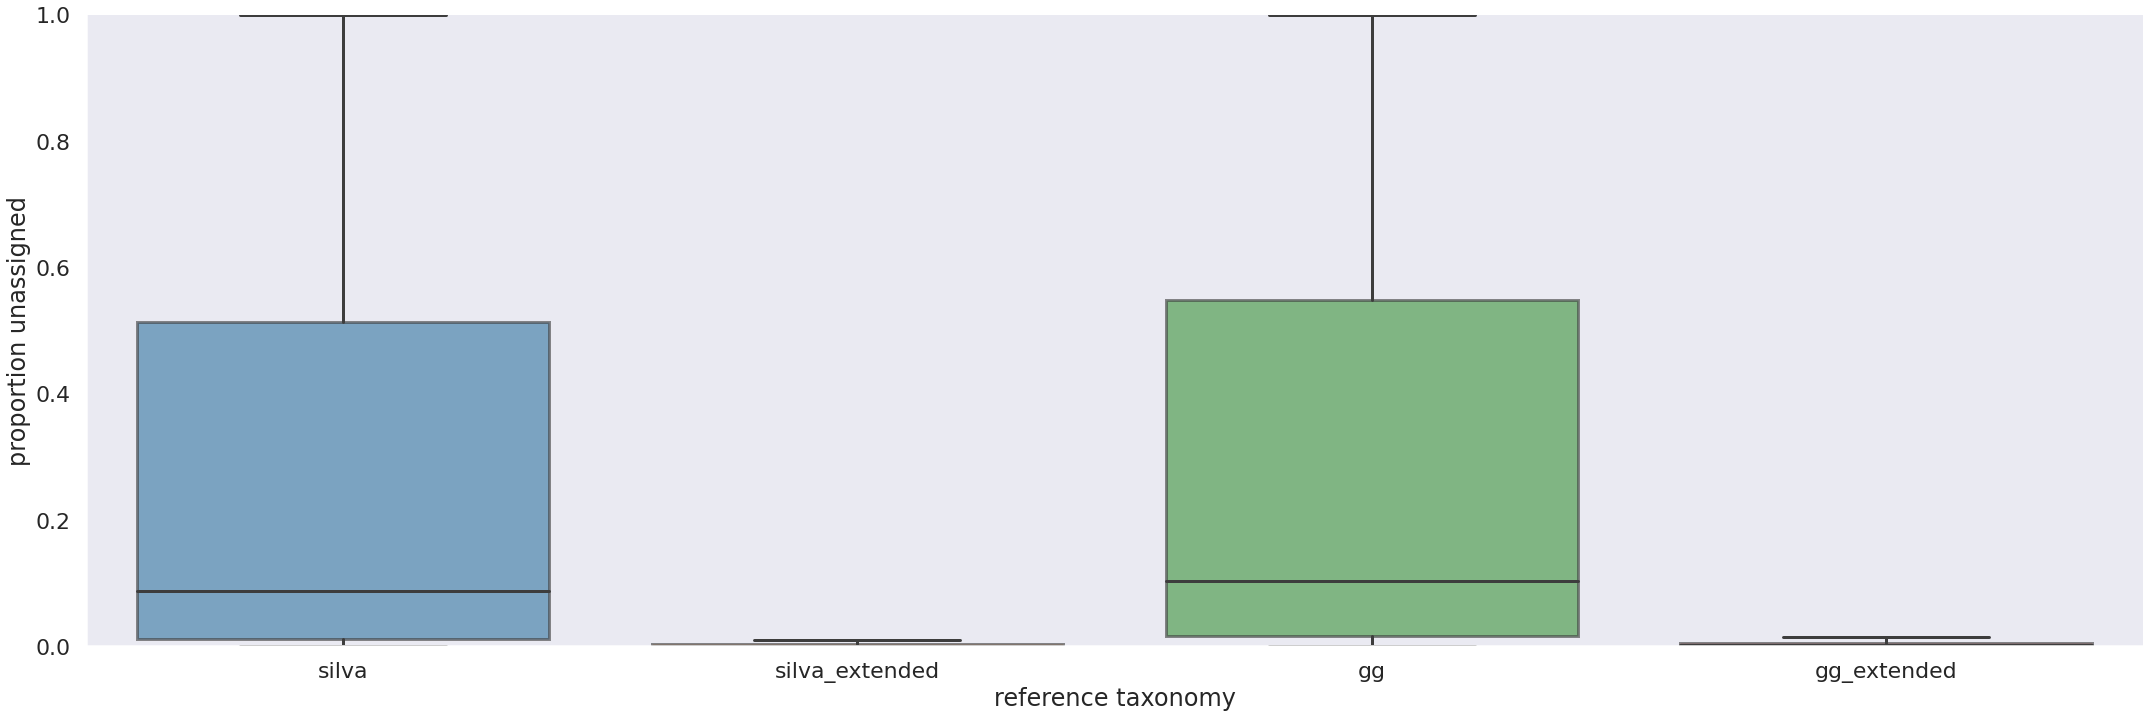

In [11]:
g = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3,
                x = "reference taxonomy", y = "proportion unassigned",
                kind = "box", data = df, fliersize = 0)
#h = sns.swarmplot(x = "reference taxonomy", dodge = True,
#                   y = "proportion unassigned",
#                   size = 3, data = df, ax = g.ax, palette = "dark")
g.set(ylim=(0, 1))

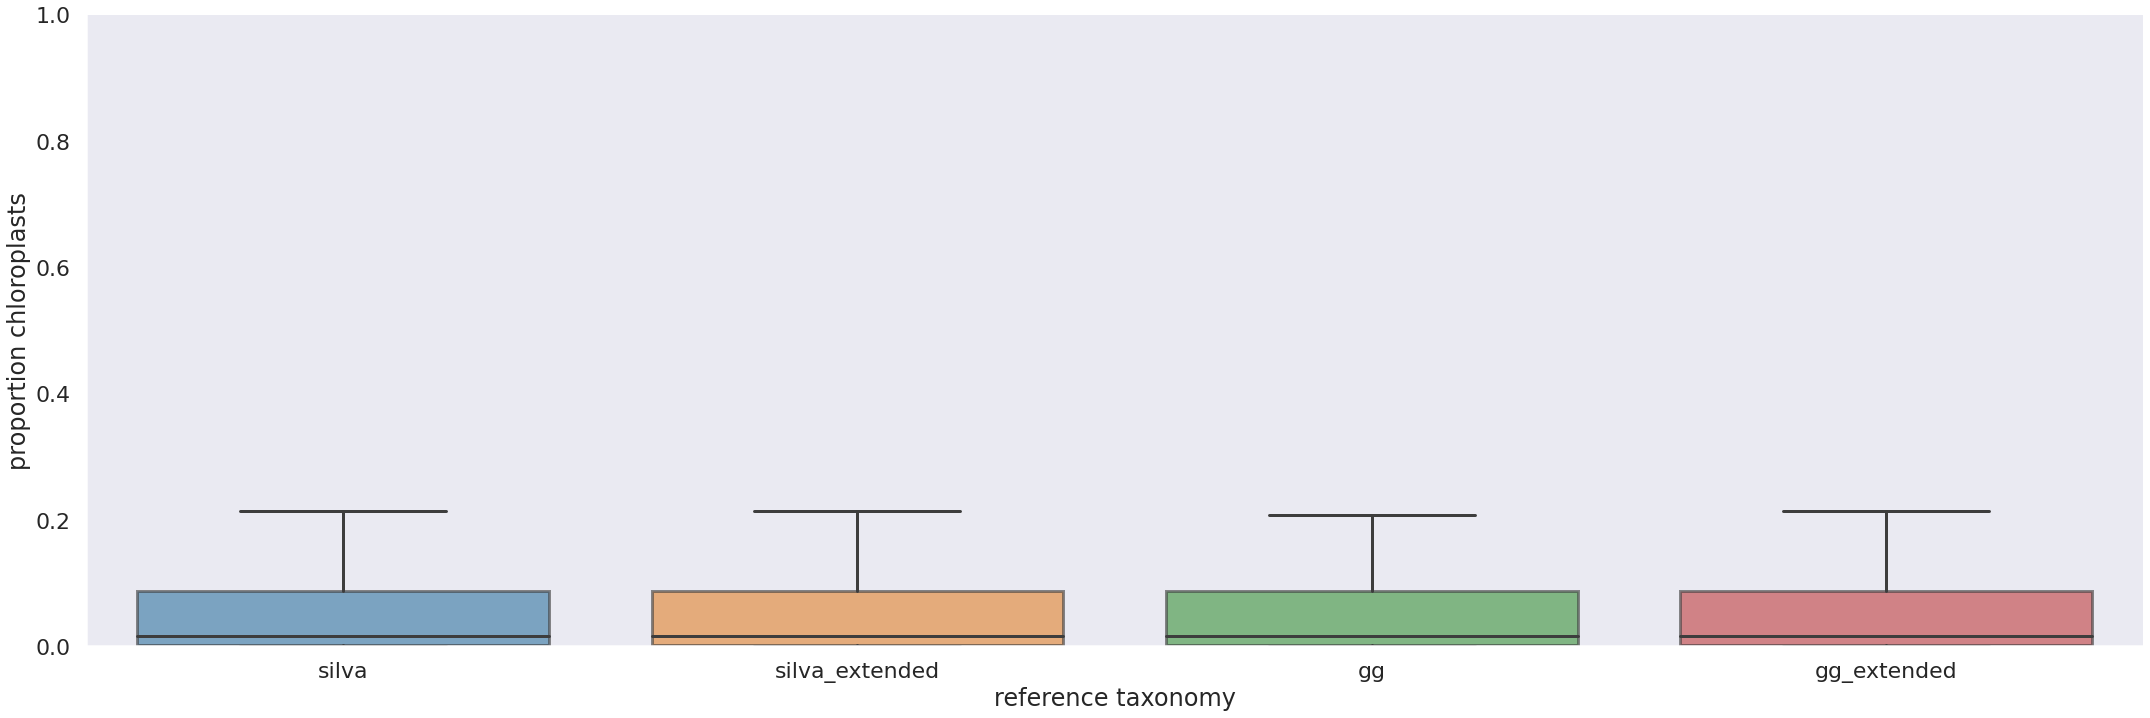

In [12]:
i = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3,
                x = "reference taxonomy", y = "proportion chloroplasts",
                kind = "box", data = df, fliersize = 0)
# j = sns.swarmplot(x = "reference taxonomy", dodge = True,
#                   y = "proportion chloroplasts",
#                   size = 3, data = df, ax = i.ax, palette = "dark")
i.set(ylim=(0, 1))

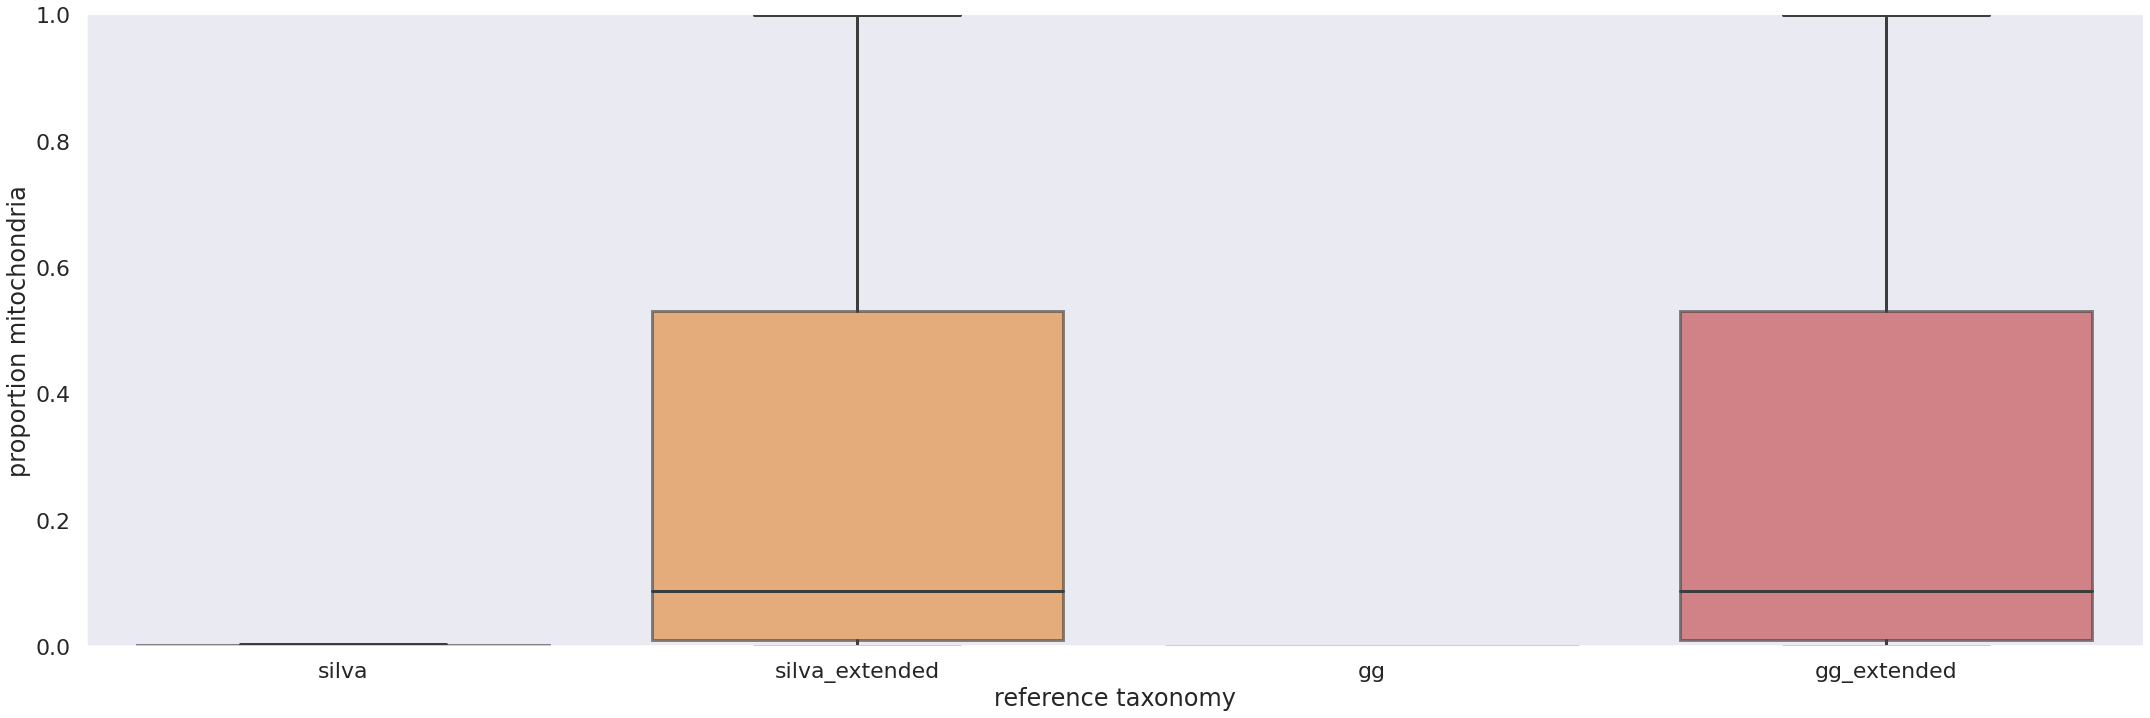

In [13]:
k = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3,
                x = "reference taxonomy", y = "proportion mitochondria",
                kind = "box", data = df, fliersize = 0)
# l = sns.swarmplot(x = "reference taxonomy", dodge = True,
#                   y = "proportion mitochondria",
#                   size = 3, data = df, ax = k.ax, palette = "dark")
k.set(ylim=(0, 1))

In [14]:
#find differentially annotated sequences
for base_reference in ['silva', 'gg']:
    base_classification = Artifact.load(working_dir + '/output/' + base_reference +
                                   '_classification_taxonomy1.qza')
    extended_classification = Artifact.load(working_dir +
                                            '/output/' + base_reference +
                                            '_extended_classification_taxonomy1.qza')
    with tempfile.TemporaryDirectory() as temp_dir:
        base_classification.export_data(temp_dir)
        base_taxonomy = pd.read_csv(temp_dir + '/taxonomy.tsv', '\t')
        extended_classification.export_data(temp_dir)
        extended_taxonomy = pd.read_csv(temp_dir + '/taxonomy.tsv', '\t')
    base_taxonomy = base_taxonomy.sort_values('Feature ID')
    base_taxonomy = base_taxonomy.reset_index()
    base_taxonomy = base_taxonomy.drop(['Consensus','index'],1)
    extended_taxonomy = extended_taxonomy.sort_values('Feature ID')
    extended_taxonomy = extended_taxonomy.reset_index()
    extended_taxonomy = extended_taxonomy.drop(['Consensus','index'],1)
    results = base_taxonomy.compare(extended_taxonomy)
    results.columns = [base_reference, 'extended']
    results['sequence'] = base_taxonomy['Feature ID']
    with open(working_dir + '/output/' + base_reference + '_differential_annotations1.fasta', 'w') as fasta_file:
        for row in results.itertuples(False, None):
            fasta_file.write('>' + row[0] + '|' + row[1] + '\n' + row[2] + '\n')
    with open(working_dir + '/output/' + base_reference + '_differential_annotations1.tsv', 'w') as tsv:
        tsv.write('sequence\t' + base_reference + '_annotation\textended_annotation\n')
        for row in results.itertuples(False, None):
            tsv.write(row[2] + '\t' + row[0] + '\t' + row[1] + '\n')

In [14]:
#generate featureids to search in qiita (feature ids == sequences in this case)
for base_reference in ['silva', 'gg']:
    with open(working_dir + '/output/' + base_reference + '_differential_annotations.tsv') as infile:
        with open(working_dir + '/output/' + base_reference + '_differential_features.txt', 'w') as outfile:
            for line in infile:
                feature = line.split('\t', 1)[0]
                outfile.write(feature + '\n')

In [15]:
!redbiom search features --from ../output/gg_differential_features.txt --context Pick_closed-reference_OTUs-Greengenes-Illumina-16S-V4-100nt-a243a1 > $(working_dir + '/output/redbiom_gg_samples.)
with open(working_dir)

SyntaxError: invalid syntax (<ipython-input-15-f1ff2604e0e7>, line 2)

In [ ]:
!redbiom search features --from ../output/silva_differential_features.txt --context Deblur-Illumina-16S-V4-100nt-fbc5b2 > test_silva.txt

In [ ]:
artifacts = []
studies = []

with open(working_dir + '/procedure/test_silva.txt') as sample_info:
    with open(working_dir + '/output/silva_diff_studies.txt', 'w') as study_info:
        for line in sample_info:
            artifact_id_plus_study_id = line.split('.', 1)[0]
            artifacts.append(artifact_id_plus_study_id)
            study_id = artifact_id_plus_study_id.split('_')[1]
            studies.append(study_id)
        artifact_counts = Counter(artifacts)
        study_counts = Counter(studies)

In [ ]:
artifact_counts

In [ ]:
max(artifact_counts, key=artifact_counts.get)

In [ ]:
!redbiom search features --help

In [ ]:
!redbiom search features --from ../output/silva_differential_features.txt --context Deblur-Illumina-16S-V4-100nt-fbc5b2 --min-count 100000 > test_silva.txt

In [ ]:
!redbiom search features --from ../output/silva_differential_features.txt --context Deblur-Illumina-16S-V4-100nt-fbc5b2 --exact > test_silva_exact.txt

In [ ]:
GCMP_compartments.export_data(working_dir + '/output')
!biom convert -i ../output/feature-table.biom -o ../output/feature_table.txt --to-tsv

In [ ]:
df = pd.read_csv(working_dir + '/output/feature_table.txt', '\t', index_col = '#OTU ID', skiprows = 1)
df['total count'] = df.sum(1)
df

In [ ]:
diffs = pd.read_csv(working_dir + '/output/differential_annotations.tsv', '\t', index_col = 'sequence')
diffs

In [ ]:
df = diffs.merge(df, 'left', left_index = True, right_index = True)
df = df.sort_values('total count', 0, False)
df

In [ ]:
df.to_csv(working_dir + '/blast.csv')

In [ ]:
i = 0
with open(working_dir + '/blast.csv', 'r+') as file:
    next(file)
    with open('real_blast.fasta', 'w') as blastfile:
        for line in file:
            while i<999900:
                sequence = line.split(',', 1)[0]
                extended_annotation = line.split(',', 3)[2]
                label = extended_annotation.split(';')[-1]
                i+=len('>' + label + '\n' + sequence + '\n')
                blastfile.write('>' + label + '\n' + sequence + '\n')
                print(i)
                break